In [92]:
import cv2
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [93]:
im = Image.open("vamp.png")
water = Image.open("water.png")
im1 = im.filter(ImageFilter.GaussianBlur(radius=10))
# plt.figure()
# plt.imshow(im)
# plt.figure()
# plt.imshow(im1)

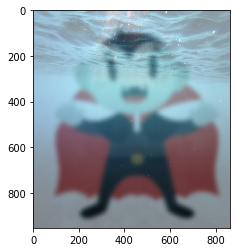

In [94]:
blended = Image.blend(im1, water, 0.5)
plt.figure()
plt.imshow(blended)

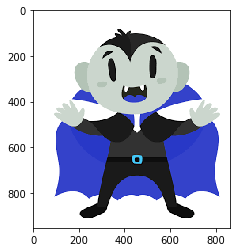

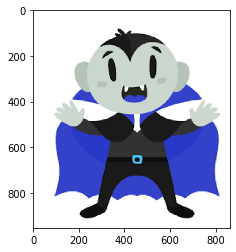

In [95]:
src = cv2.imread('Vamp.png', cv2.IMREAD_UNCHANGED)
dst = cv2.GaussianBlur(src, (5, 5), 0)
plt.figure()
plt.imshow(src)
plt.figure()
plt.imshow(dst)

In [99]:
def resize(im1, im2):
    "Returns im2 with the same dimensions as im1"
    return ImageOps.fit(im2, (im1.width, im1.height), Image.ANTIALIAS)

In [100]:
def sizeBlend(im1, im2, alpha):
    "Resizes im2 and blends im1 and im2 with the given alpha"
    im2 = resize(im1, im2)
    return Image.blend(im1, im2, alpha)

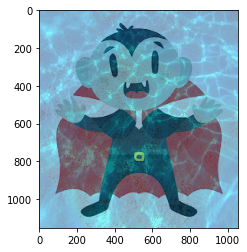

In [103]:
#Adeet - Blend Test
from PIL import Image, ImageOps
im = Image.open("vamp2.png")
im2 = Image.open("water2.png")
imshow = sizeBlend(im, im2, 0.5)
plt.imshow(imshow)